# Homework 3


In this homework, we will implement a logistic regression from scratch. Your jobs

1. Implement the objective function and prediction function.
2. Implement the stochastic gradient descent algorithm to train the logistic regression.
3. Implement the stochastic gradient descent algorithm to train the logistic regression.
4. Submit the .IPYNB file to Canvas.
    - Missing the execution output after each cell may hurt your grade.


**In this homework, you are not allowed to import extra packages except those have been imported.
You need to write the plain Numpy code to implement the algorithms and cannot use scikit learn in your implementation.**

# Part 0: Data processing

- Load the data using sklearn.
- Preprocess the data.

## Load the data

In [24]:
from sklearn import datasets
from sklearn import preprocessing
import numpy as np
import pandas as pd

data = pd.read_csv('FinalData_num.csv')
##print(data)

        

test_data = data.loc[data['year'] == 2021]
train_data = data.loc[data['year']!= 2021]
x_test = test_data.drop(['Expected', 'team', 'opponent','year','month','day','Date'], axis=1)
x_train = train_data.drop(['Expected', 'team', 'opponent','year','month','day','Date'], axis=1)
y_test = test_data['Expected']
y_train = train_data['Expected']



MAX_EPOCH = 2000
np.random.seed(1)
alpha = 0.01

##x_sparse, y = datasets.load_svmlight_file('diabetes')
##x = x_sparse.todense()

x = data.to_numpy()

##print(x)

x = np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)

print('Shape of x: ' + str(data.shape))
print('Shape of y: ' + str(data['Expected'].shape))

Shape of x: (20744, 24)
Shape of y: (20744,)


## Partition to training and test sets

In [25]:
# partition the data to training and test sets
##from sklearn.model_selection import train_test_split
##x_train, x_test, y_train, y_test = train_test_split(x, y)

## Convert to numpy
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (17856, 17)
Shape of x_test: (2888, 17)
Shape of y_train: (17856,)
Shape of y_test: (2888,)


## Feature Standardization

Min-max normalization and standardization are two popular feature scaling methods.

- Min-max normalization scales the features to the interval $[0, 1]$.
- Standardization makes the features have zero mean and unit variance.

In [26]:
# Standardization
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lg = LogisticRegression()
lg.fit(x_train, y_train)
print('Accuracy for training data', accuracy_score(lg.predict(x_train), y_train))
print('Accuracy for testing data', accuracy_score(lg.predict(x_test), y_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Part 1. Functions

The objective function is $L(\mathbf{w}; \mathbf{X}, \mathbf{y})=\frac{1}{n} \sum_{i=1}^n l (y_j w^T x_j)$, where $l(z) = log(1+e^{-z})$.
Given an instance of w, you can always calculate the objective value for this dataset.
This value is considered as a mediate metric for the gradient descent or stochastic gradient descent.

In [134]:
# (10 pts)

def calc_obj_val(x, y, w):
    '''
    Input: 
        x: a (n,d) ndarray
        y: a (n,) ndarray
        w: a (d,) ndarray
    Output:
        obj_val: float, the value of the objective function given an instance of w.
    '''
    ###### Add your code here
    n = len(x)
    l = lambda z : np.log(1+np.exp(-z))
    obj_vals = []
    for i in range(n):
        obj_vals.append(l(y[i]*(np.dot(w.T,x[i]))))
    
    obj_val = 1/n * sum(obj_vals)
    ######
    
    return obj_val


Given any instance of w, you can always make predictions by y_pred = f(x)=sign(wx).

In [135]:
# 10 pts

def predict(x, w):
    '''
    Inputs:
        x: a (n,d) ndarray
        w: a (d,) ndarray
    Return:
        y_pred: a (n,) ndarray, the predictions
    '''
    
    ###### Add your code here
    sign = lambda val : 1.0 if val >= 0 else -1.0
    y_pred = []
    for x_i in x:
        y_pred.append(sign(np.dot(x_i, w)))
    
    y_pred = np.array(y_pred)
    ######
    
    return y_pred

# Part 2: Gradient Descent Implementation

## Calculate the full gradient

The gradient at Step $t$ is
$$g_t =  \frac{1}{n} \sum_{i=1}^n  \frac{-y_j x_j}{1 + exp(y_j w_t^T x_j)} $$

In [136]:
# 20 pts

def calc_full_gradient(x, y, w):
    '''
     This function computes the gradient.
     Inputs:
         x: a (n,d) ndarray
         y: a (n,) ndarray
         w: a (d,) ndarray
     Return:
         w_grad: a (d,) ndarray, full gradient
    '''

    
    ###### Add your code here
    n = len(x)
    grad = lambda x_i, y_i : (-y_i*x_i) / (1 + np.exp(y_i*np.dot(w.T, x_i)))
    w_grads = []
    for i in range(n):
        w_grads.append(grad(x[i], y[i]))
    
    w_grad = 1/n * sum(w_grads)
    ######
    return w_grad

## Update the weights using gradient descent

Then, the weights w is updated iteratively using the decent.
The pseudo-code is given below:

for each iteration $t$ untill max_epoch:  
 &nbsp; &nbsp; w_gd = calc_full_gradient()  
 &nbsp; &nbsp; update w by $w_t$ = $w_{t-1}$ - alpha * w_gd  
 &nbsp; &nbsp; obj_val = calc_obj_val()  
 &nbsp; &nbsp; append the current objective value to `objvals`.  

In [137]:
# 20 pts

def logistic_regression_gd(x, y, w, alpha, max_epoch=MAX_EPOCH):
    '''
    Gradient descent for solving logistic regression
    Inputs:
        x: a (n,d) ndarray
        y: a (n,) ndarray
        alpha: a scalar
        max_epoch: an integer, the maximal epochs
    Return:
        w: a (d,) ndarray
        objvals: a list of objective values for all epochs
    '''

    objvals = [] # store the objective values
    
    ###### Add your code here
    for t in range(1, max_epoch):
        w_gd = calc_full_gradient(x, y, w)
        w = w - alpha * w_gd
        obj_val = calc_obj_val(x, y, w)
        objvals.append(obj_val)
    
    ######
    
    return w, objvals

## Start to train a logistic regression using full GD

In [138]:
# Initiate w
d = x_train.shape[1]
w = np.zeros(d)

w_gd, objvals_gd = logistic_regression_gd(x_train, y_train, w, alpha)

## Visualize the objective values

Text(0, 0.5, 'Objective Value')

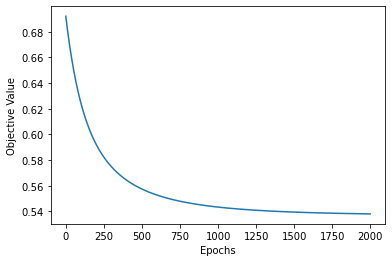

In [139]:
import matplotlib.pyplot as plt
plt.plot(objvals_gd)
plt.xlabel('Epochs')
plt.ylabel('Objective Value')

## Test your weights on training and testing data separately

In [140]:
# evaluate training accuracy
y_train_pred = predict(x_train, w_gd)
acc_train = np.mean(y_train_pred == y_train)
print('Accuracy for training data', acc_train)

Accuracy for training data 0.7413194444444444


In [141]:
# evaluate test accuracy
y_test_pred = predict(x_test, w_gd)
diff = np.abs(y_test_pred - y_test) / 2
acc_test = np.mean(y_test_pred == y_test)
print('Accuracy for training data', acc_test)

Accuracy for training data 0.7708333333333334


# Part 3: Stochastic gradient descent (SGD) implementation


## Calculate a stochastic gradient

The stochastic gradient is calculated using a single data point (x_j, y_j) rather than the whole dataset:
$$g_t =  \frac{-y_j x_j}{1 + exp(y_j w_t^T x_j)} $$

In [142]:
# 20 pts

def calc_sgd_gradient(x_j, y_j, w):
    '''
    Calculate the stochastic gradient at (x_j, y_j)
    Inputs:
        x_j: a (d,) ndarray
        y_j: a scalar
        w: a (d,) ndarray
    Return:
        w_grad: a (d,) vector
    '''
       
    ###### Add your code here
    grad = lambda x_i, y_i : (-y_i*x_i) / (1 + np.exp(y_i*np.dot(w.T, x_i)))
    w_grad = grad(x_j, y_j)
    
    ######
    return w_grad

## Update weights using the stochastic gradient

The stochastic gradient fluctuates, but it is acceptable for gradient descent.
If a stochastic gradient is adopted, the optimization is known as stochastic gradient descent.
Here is the pseudo-code:

for each epoch $t$ untill max_epoch:  
 &nbsp; &nbsp; let n is the rows of the features  
 &nbsp; &nbsp; generate an index list from 0 to n-1  
 &nbsp; &nbsp; shuffle the index list  
 &nbsp; &nbsp; for each index $j$ in this list:  
 &nbsp; &nbsp;  &nbsp; &nbsp; $w_{t*n+j}$ = calc_sgd_gradient($x_j$, $y_j$, $w_{t*n-1}$)  
 &nbsp; &nbsp;  &nbsp; &nbsp; update w by $w_{t*n+j}$ = $w_{t*n+j-1}$ - alpha * w_sgd  
 &nbsp; &nbsp; obj_val = calc_obj_val()  
 &nbsp; &nbsp; append the current objective value to `objvals`.  

In [143]:
# 20 pts

def logistic_regression_sgd(x, y, w, alpha, max_epoch=MAX_EPOCH):
    '''
    Stochastic gradient descent for solving logistic regression
    Inputs:
        x: a (n,d) ndarray
        y: a (n,) ndarray
        alpha: a scalar
        max_epoch: an integer, the maximal epochs
    Return:
        w: a (d,) ndarray
        objvals: a list of objective values for all epochs
    '''
    
    objvals = [] # store the objective values
    
    ###### Add your code here
    for t in range(max_epoch):
        n = len(x)
        index_list = np.arange(n)
        np.random.shuffle(index_list)
        for j in index_list:
            w_sgd = calc_sgd_gradient(x[j], y[j], w)
            w = w - alpha * w_sgd
        
        obj_val = calc_obj_val(x, y, w)
        objvals.append(obj_val)
    ######
    #print(f'type w: {type(w)} shape: {w.shape}, type objvals: {type(objvals)}')
    return w, objvals

## Start to train a logistic regression using SGD

In [144]:
# initiate w
d = x_train.shape[1]
w = np.zeros(d)

w_sgd, objvals_sgd = logistic_regression_sgd(x_train, y_train, w, alpha)

## Visualize the objective values

Text(0, 0.5, 'Objective Value')

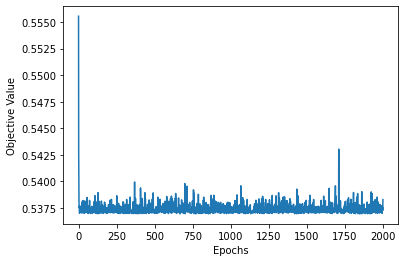

In [145]:
import matplotlib.pyplot as plt
plt.plot(objvals_sgd)
plt.xlabel('Epochs')
plt.ylabel('Objective Value')

## Test your weights on training and testing data separately

In [146]:
# evaluate training accuracy
y_train_pred = predict(x_train, w_sgd)
acc_train = np.mean(y_train_pred == y_train)
print('Accuracy for training data', acc_train)

Accuracy for training data 0.734375


In [147]:
# evaluate test accuracy
y_test_pred = predict(x_test, w_sgd)
acc_train = np.mean(y_test_pred == y_test)
print('Accuracy for training data', acc_test)

Accuracy for training data 0.7708333333333334


# Part 4: Compare GD and SGD

Now you have implemented gradient descent and stochastic gradient descent.
You can compare the optimization procedure and plot the curves of the objective values.

Text(0, 0.5, 'Objective Value')

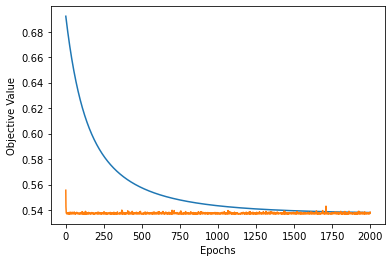

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(objvals_gd)
plt.plot(objvals_sgd)
plt.xlabel('Epochs')
plt.ylabel('Objective Value')